<font size="+3"><strong>3. Chi-square test</strong></font>

In the previous lesson, we identified a subset of applicants who don't complete the admissions quiz. Then we developed a null and alternative hypothesis that we want to test in an experiment.

In this lesson, we'll conduct our experiment. First, we'll determine how long we need to run our experiment in order to detect a significant difference between our control and treatment groups. Then we'll run our experiment and evaluate our results using a chi-square test. 

<div class="alert alert-block alert-warning">
<b>Warning:</b> The database has changed since this videos for this lesson were filmed. So don't worry if you don't get exactly the same numbers as the instructor for the tasks in this project.
</div>

> Note: Replace `ip_of_mongo_device` with your actual MongoDB IP address.



In [43]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import scipy
from IPython.display import VimeoVideo
from pymongo import MongoClient
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.power import GofChisquarePower
from teaching_tools.ab_test.experiment import Experiment
from teaching_tools.ab_test.reset import Reset

# Reset database
r = Reset("192.145.110.2")
r.reset_database()

Reset 'ds-applicants' collection. Now has 5025 documents.
Reset 'mscfe-applicants' collection. Now has 1335 documents.


In [4]:
VimeoVideo("742459144", h="0f1aa2db83", width=600)

# Preparing the Experiment

## Connect to Database

Just like in the previous module, the first thing we need to do is connect to our MongoDB server and turn our collection of interest into a variable.

<div style="padding: 1em; border: 1px solid #f0ad4e; border-left: 6px solid #f0ad4e; background-color: #fcf8e3; color: #8a6d3b; border-radius: 4px;">

<strong>🛠️ Instruction:</strong> Locate the IP address of the machine running MongoDB and assign it to the variable <code>host</code>. Make sure to use a <strong>string</strong> (i.e., wrap the IP in quotes).<br><br>

<strong>⚠️ Note:</strong> The IP address is <strong>dynamic</strong> — it may change every time you start the lab. Always check the current IP before proceeding.

</div>
<img src="images/mongo_ip.png" alt="MongoDB" width="600"/>


In [22]:
host = "192.145.110.2"

**Task 7.3.1:** Assign the `"ds-applicants"` collection in the `"wqu-abtest"` database to the variable name `ds_app`.

> Note: When using the `MongoClient` class, specify the host by passing `host=host` as the first argument. For example: `MongoClient(host=host, port=27017)`


> MongoDB server is running at `host` on port `27017`.

- [What's a MongoDB collection?](../%40textbook/11-databases-mongodb.ipynb#Collections)
- [Access a collection in a database using PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Collections)

In [23]:
client = MongoClient(host=host,port=27017)
df=client["wqu-abtest"]
ds_app = df["ds-applicants"]
for doc in ds_app.find().limit(5):
    print(doc)
print("client:", type(client))
print("ds_app:", type(ds_app))

{'_id': ObjectId('68aab8156eb0e521ee7419ba'), 'createdAt': datetime.datetime(2022, 5, 13, 15, 2, 44), 'firstName': 'Terry', 'lastName': 'Hassler', 'email': 'terry.hassler28@yahow.com', 'birthday': datetime.datetime(1998, 4, 29, 0, 0), 'gender': 'male', 'highestDegreeEarned': "Bachelor's degree", 'countryISO2': 'GB', 'admissionsQuiz': 'incomplete'}
{'_id': ObjectId('68aab8156eb0e521ee7419bb'), 'createdAt': datetime.datetime(2022, 5, 23, 10, 36, 56), 'firstName': 'Alan', 'lastName': 'Noble', 'email': 'alan.noble91@hotmeal.com', 'birthday': datetime.datetime(1999, 3, 3, 0, 0), 'gender': 'male', 'highestDegreeEarned': "Bachelor's degree", 'countryISO2': 'NG', 'admissionsQuiz': 'complete'}
{'_id': ObjectId('68aab8156eb0e521ee7419bc'), 'createdAt': datetime.datetime(2022, 5, 11, 9, 35, 39), 'firstName': 'Ruth', 'lastName': 'Vedovelli', 'email': 'ruth.vedovelli46@microsift.com', 'birthday': datetime.datetime(1994, 8, 16, 0, 0), 'gender': 'female', 'highestDegreeEarned': "Master's degree", 'co

## Calculate Power

One of a Data Scientist's jobs is to help others determine what's  meaningful information and what's not. You can think about this as distinguishing between **signal** and **noise**. As the author [Nate Silver](https://en.wikipedia.org/wiki/The_Signal_and_the_Noise) puts it, "The signal is the truth. The noise is what distracts us from the truth."

In our experiment, we're looking for a signal indicating that applicants who receive an email are more likely to complete the admissions quiz. If signal's strong, it'll be easy to see. A much higher number of applicants in our treatment group will complete the quiz. But if the signal's weak and there's only a tiny change in quiz completion, it will be harder to determine if this is a meaningful difference or just random variation. How can we separate signal from noise in this case? The answer is **statistical power**.

To understand what statistical power is, let's imagine that we're radio engineers building an antenna. The size of our antenna would depend on the type of signal we wanted to detect. It would be OK to build a low-power antenna if we only wanted to detect strong signals, like a car antenna that picks up your favorite local music station. But our antenna wouldn't pick up weaker signals — like a radio station on the other side of the globe. For weaker signals, we'd need something with higher power. In statistics, power comes from the number of observations you include in your experiment. In other words, the more people we include, the stronger our antenna, and the better we can detect weak signals. 

To determine exactly how many people we should include in our study, we need to do a **power calculation**. 

In [7]:
VimeoVideo("734517993", h="624e1cd2ea", width=600)

In [8]:
VimeoVideo("734517709", h="907b2d3102", width=600)

**Task 7.3.2:** First, instantiate a `GofChisquarePower` object and assign it to the variable name `chi_square_power`. Then use it to calculate the `group_size` needed to detect an effect size of `0.2`, with an alpha of `0.05` and power of `0.8`.

- [What's statistical power?](../%40textbook/20-statistics.ipynb#Power)
- [What's effect size?](../%40textbook/20-statistics.ipynb#Effect-Size)
- [Perform a power calculation using statsmodels.](../%40textbook/20-statistics.ipynb#Test-for-Independence)

In [24]:
chi_square_power =GofChisquarePower()
group_size = math.ceil(chi_square_power.solve_power(effect_size=0.2,alpha=0.05,power=0.8))

print("Group size:", group_size)
print("Total # of applicants needed:", group_size * 2)

Group size: 197
Total # of applicants needed: 394


The results here are telling us that if we want to detect an effect size of 0.2 we need a group size of about 200 people. Since our experiment has two conditions (treatment and control, or email and no email), that means we need a total of about 400 applicants in our experiment.

But what about detecting other effect sizes? If we needed to detect a *larger* effect size, we'd need *fewer* applicants. If we needed to detect a *smaller* effect size, we'd need *more* applicants. One way to visualize the relationship between effect size, statistical power, and number of applicants is to make a graph.

In [10]:
VimeoVideo("734517244", h="44460ba891", width=600)

**Task 7.3.3:** Use `chi_square_power` to plot a power curve for three effect sizes: `0.2`, `0.5`, and `0.8`. The x-axis should be the number of observations, ranging from `0` to twice the `group_size` from the previous task. 

- [Plot a power calculation using statsmodels.](../%40textbook/20-statistics.ipynb#Test-for-Independence)

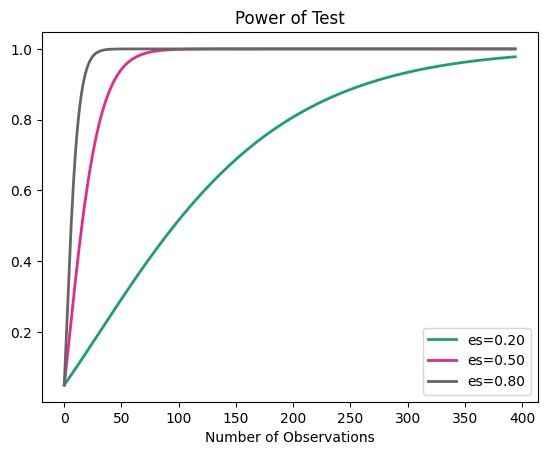

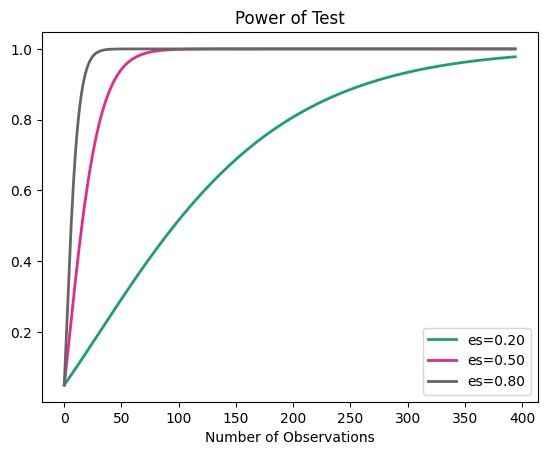

In [25]:
n_observations = np.arange(0,group_size * 2+1)
effect_sizes = np.array([0.2,0.5,0.8])

# Plot power curve using `chi_square_power`
chi_square_power.plot_power(
    dep_var="nobs",
    nobs=n_observations,
    effect_size=effect_sizes,
    alpha=0.05,
    n_bins=2
    
)

## Calculate Subjects per Day

In the previous lesson, we decided that our experiment would focus on the subset of applicants who don't take the admissions quiz immediately after creating an account. We know we need around 400 observations from this subset, but how long do we need to run our experiment for in order to get that number?

To answer that question, we first need to calculate how many such applicants open an account each day.

In [12]:
VimeoVideo("734516984", h="f8c2ae9e0e", width=600)

**Task 7.3.4:** Use the [`aggregate`](https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.aggregate) method to calculate how many new accounts were created each day included in the database.

- [Perform aggregation calculations on documents using PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Analyzing-Data)
- [Use the `$dateTrunc` operator to truncate a date in PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Analyzing-Data)
- [Use the `$group` operator in an aggregation in PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Aggregation)
- [Use the `$match` operator in an aggregation in PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Aggregation)

In [30]:
result = ds_app.aggregate([
    {
        "$match": {
            "admissionsQuiz": "incomplete"
        }
    },
    {
        "$group": {
            "_id": {
                "$dateTrunc": {
                    "date": "$createdAt",  
                    "unit": "day"
                }
            },
            "count": { "$sum": 1 }
        }
    },
   
])


Now we'll read our query result into a Series.

In [14]:
VimeoVideo("734516829", h="9c7014eb8d", width=600)

**Task 7.3.5:** Read your `result` from the previous task into the Series `no_quiz`. The Series index should be called `"date"`, and the name should be `"new_users"`.

- [Create a DataFrame from a dictionary using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)
- [Rename columns in a DataFrame using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Rename-a-Series)
- [Set and reset the index of a DataFrame in pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrame-Indices)
- [Sort a DataFrame or Series in pandas.](../%40textbook/03-pandas-getting-started.ipynb#Sorting)

In [31]:
no_quiz = (
    pd.DataFrame(list(result))
    .rename({"_id":"date","count":"new_users"},axis=1).set_index("date").sort_index().squeeze()
    
)

print("no_quiz type:", type(no_quiz))
print("no_quiz shape:", no_quiz.shape)
print(no_quiz.head())

no_quiz type: <class 'pandas.core.series.Series'>
no_quiz shape: (30,)
date
2022-05-01    37
2022-05-02    49
2022-05-03    43
2022-05-04    48
2022-05-05    47
Name: new_users, dtype: int64


Okay! Let's see what we've got here by creating a histogram.

In [32]:
VimeoVideo("734516524", h="c1e506e702", width=600)

**Task 7.3.6:** Create a histogram of `no_quiz`. Be sure to label the x-axis `"New Users with No Quiz"`, the y-axis `"Frequency [count]"`, and use the title `"Distribution of Daily New Users with No Quiz"`.

- [Create a histogram using pandas.](../%40textbook/07-visualization-pandas.ipynb#Histograms)

Text(0.5, 1.0, 'Distribution of Daily New Users with No Quiz')

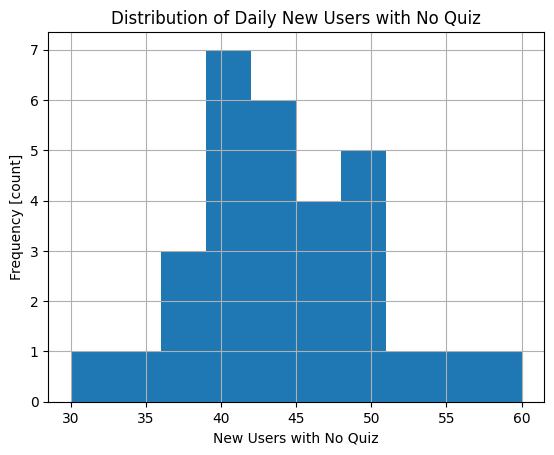

In [35]:
# Create histogram of `no_quiz`
no_quiz.hist()
# Add axis labels and title
plt.xlabel("New Users with No Quiz")
plt.ylabel("Frequency [count]")
plt.title("Distribution of Daily New Users with No Quiz")

We can see that somewhere between 30–60 no-quiz applicants come to the site every day. But how can we use this information to ensure that we get our 400 observations? We need to calculate the mean and standard deviation of this distribution. 

In [ ]:
VimeoVideo("734516130", h="a93fabac0f", width=600)

**Task 7.3.7:** Calculate the mean and standard deviation of the values in `no_quiz`, and assign them to the variables `mean` and `std`, respectively.

- [Calculate summary statistics for a DataFrame or Series in pandas.](../%40textbook/05-pandas-summary-statistics.ipynb#Working-with-Summary-Statistics)

In [36]:
mean = no_quiz.mean()
std = no_quiz.std()
print("no_quiz mean:", mean)
print("no_quiz std:", std)

no_quiz mean: 43.6
no_quiz std: 6.398275629767974


The exact answers you'll get here will be a little different, but you should see a mean around 40 and a standard deviation between 7 and 8. Taking those rough numbers as a guide, how many days do we need to run the experiment to make sure we get to 400 users?

Intuitively, you might think the answer is 10 days, because $10 \cdot 40 = 400$. But we can't guarantee that we'll get 40 new users every day. Some days, there will be fewer; some days, more. So how can we estimate how many days we'll need? Statistics!

The distribution we plotted above shows how many no-quiz applicants come to the site *each day*, but we can use that mean and standard deviation to create a new distribution — one for the sum of no-quiz applicants over *several days*. Let's start with our intuition, and create a distribution for 10 days.

In [37]:
VimeoVideo("742459088", h="1962b016f9", width=600)

**Task 7.3.8:** Calculate the mean and standard deviation of the probability distribution for the total number of sign-ups over 10 days. 

- [What's the central limit theorem?](../%40textbook/20-statistics.ipynb#Central-Limit-Theorem)

In [38]:
days = 10
sum_mean = days*mean
sum_std = std*math.sqrt(days)
print("Mean of sum:", sum_mean)
print("Std of sum:", sum_std)

Mean of sum: 436.0
Std of sum: 20.233124087615032


With this new distribution, we want to know what the probability is that we'll have 400 or more no-quiz applicants after 10 days. We can calculate this using the **cumulative density function** or CDF. The CDF will give us the probability of having 400 or fewer no-quiz applicants, so we'll need to subtract our result from 1.

**Task 7.3.9:** Calculate the probability of getting 400 or more sign-ups over three days.

- [What's a cumulative density function?](../%40textbook/20-statistics.ipynb#Cumulative-Density-Functions)
- [Calculate the cumulative density function for a normal distribution using SciPy.](../%40textbook/20-statistics.ipynb#Cumulative-Density-Functions)

In [41]:
VimeoVideo("742459015", h="33ad7b37ca", width=600)

In [50]:
prob_400_or_fewer =scipy.stats.norm.cdf(group_size*2,loc=sum_mean,scale=sum_std)
prob_400_or_greater = 1-prob_400_or_fewer

print(
    f"Probability of getting 400+ no_quiz in {days} days:",
    round(prob_400_or_greater, 3),
)

Probability of getting 400+ no_quiz in 10 days: 0.981


Again, the exact probability will change every time we regenerate the database, but there should be around a 90% chance that we'll get the number of applicants we need over 10 days. 

Since we're talking about finding an optimal timeframe, though, try out some other possibilities. Try changing the value of `days` in Task 7.3.8, and see what happens when you run 7.3.9. Cool, huh?

# Running the Experiment

Okay, now we know how many applicants we need and what the timeframe needs to be. Let's actually run the experiment!

In [51]:
VimeoVideo("734515713", h="7702f5163d", width=600)

**Task 7.3.10:** Using the `Experiment` object created below, run your experiment for the appropriate number of days.

In [52]:
exp = Experiment(repo=client, db="wqu-abtest", collection="ds-applicants")
exp.reset_experiment()
result = exp.run_experiment(days=10)
print("result type:", type(result))
result

result type: <class 'dict'>


{'acknowledged': True, 'inserted_count': 1557}

# Evaluating Experiment Results

After all that work, the actual running of the experiment might seem a little anticlimactic. This is because we automated the process and are working with synthetic data. Let's look at our results?

## Get Data

First, get the data we need by finding just the people who were part of the experiment...

In [53]:
VimeoVideo("734515601", h="759340caf1", width=600)

**Task 7.3.11:** Query `ds_app` to find all the documents that are part of the experiment. 

- [Query a collection using PyMongo.](../%40textbook/11-databases-mongodb.ipynb#Retrieving-Data)

In [65]:
result = ds_app.find({"inExperiment":True})
print("results type:", type(result))

results type: <class 'pymongo.synchronous.cursor.Cursor'>


...and load them into a DataFrame.

In [63]:
VimeoVideo("734515308", h="8308ce4a22", width=600)

**Task 7.3.12:** Load your `result` from the previous task into the DataFrame `df`. Be sure to drop any rows with `NaN` values.

- [Create a DataFrame from a dictionary using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Working-with-DataFrames)
- [Drop rows with missing values from a DataFrame using pandas.](../%40textbook/03-pandas-getting-started.ipynb#Dropping-Rows)

In [66]:
df = pd.DataFrame(result).dropna()

print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (436, 12)


,_id,createdAt,firstName,lastName,email,birthday,gender,highestDegreeEarned,countryISO2,admissionsQuiz,inExperiment,group
0,68aac0876eb0e521ee74329f,2025-08-28 11:16:33,Nathan,Walker,nathan.walker97@microsift.com,1998-04-30,male,Master's degree,PK,complete,True,email (t)
1,68aac0876eb0e521ee7432a3,2025-08-24 17:33:31,Russell,Koester,russell.koester72@microsift.com,2000-08-06,male,Bachelor's degree,PK,complete,True,email (t)
2,68aac0876eb0e521ee7432a4,2025-09-02 11:16:12,Michael,Depasquale,michael.depasquale34@gmall.com,2000-10-21,male,Master's degree,BD,complete,True,email (t)
3,68aac0876eb0e521ee7432aa,2025-08-30 09:41:56,Fay,Miller,fay.miller53@hotmeal.com,1988-12-28,female,Master's degree,NG,complete,True,email (t)
4,68aac0876eb0e521ee7432ac,2025-09-01 14:39:43,Robert,Shields,robert.shields94@microsift.com,2003-02-14,male,High School or Baccalaureate,ET,complete,True,email (t)


## Build Contingency Table

Now that the results are in a DataFrame, we can start pulling apart what we found. Let's start by making a table showing how many people did and didn't complete the quiz across our two groups.

In [67]:
VimeoVideo("734514187", h="9063c1eccf", width=600)

**Task 7.3.13:** Use pandas `crosstab` to create a 2x2 table `data` that shows how many applicants in each experimental group completed and didn't complete the admissions quiz. After you're done, submit your `data` to the grader.

- [What's cross tabulation?](../%40textbook/20-statistics.ipynb#Contingency-Tables)
- [Compute a cross tabulation in pandas.](../%40textbook/20-statistics.ipynb#Contingency-Tables) 

In [85]:
data = pd.crosstab(index=df["group"],columns=df["admissionsQuiz"],normalize=False)

print("data type:", type(data))
print("data shape:", data.shape)
data

data type: <class 'pandas.core.frame.DataFrame'>
data shape: (2, 2)


admissionsQuiz,complete,incomplete
group,,
email (t),16,202
no email (c),12,206


Just to make it easier to see, let's show the results in a side-by-side bar chart.

In [69]:
VimeoVideo("734513651", h="cc012589ac", width=600)

**Task 7.3.14:** Create a function that returns side-by-side bar chart from `data`, showing the number of complete and incomplete quizzes for both the treatment and control groups. Be sure to label the x-axis `"Group"`, the y-axis `"Frequency [count]"`, and use the title `"Admissions Quiz Completion by Group"`.

- [What's a bar chart?](../%40textbook/07-visualization-pandas.ipynb#Bar-Charts)
- [Create a bar chart using plotly express.](../%40textbook/08-visualization-plotly.ipynb#Bar-Chart)<span style='color: transparent; font-size:1%'>WQU WorldQuant University Applied Data Science Lab QQQQ</span>

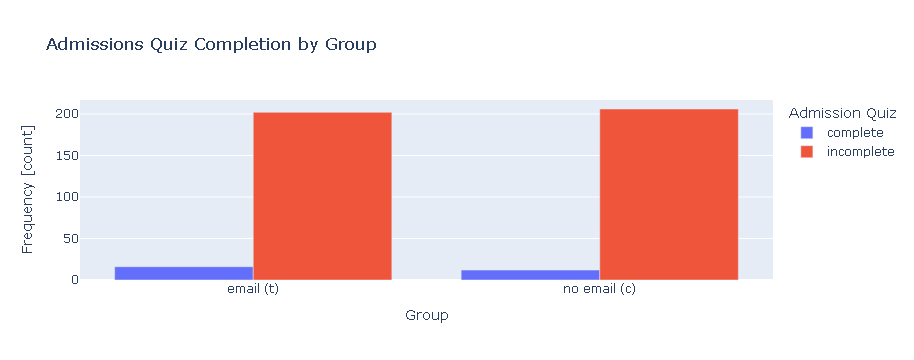

In [72]:
def build_contingency_bar():
    # Create side-by-side bar chart
    fig = px.bar(
        data_frame=data,
        barmode="group",
        title="Admissions Quiz Completion by Group"
    )
    fig.update_layout(
        xaxis_title="Group",
        yaxis_title="Frequency [count]",
        legend={"title":"Admission Quiz"}
    )
    # Set axis labels
   
    return fig


build_contingency_bar().show()

Without doing anything else, we can see that people who got an email actually did complete the quiz more often than people who didn't. So can we conclude that, as a general rule, applicants who receive an email are more likely to complete quiz. No, not yet. After all, the difference we see could be due to chance. 

In order to determine if this difference is more than random variation, we need to take our results, put them into a **contingency table**, and run a statistical test.

In [73]:
VimeoVideo("734512752", h="92e79c3f89", width=600)

**Task 7.3.15:** Instantiate a `Table2x2` object named `contingency_table`, using the values from the `data` you created in the previous task.

- [What's a contingency table?](../%40textbook/20-statistics.ipynb#Contingency-Tables) 
- [Create a contingency table using statsmodels.](../%40textbook/20-statistics.ipynb#Contingency-Tables) 

In [74]:
contingency_table = Table2x2(data.values)

print("contingency_table type:", type(contingency_table))
contingency_table.table_orig

contingency_table type: <class 'statsmodels.stats.contingency_tables.Table2x2'>


array([[ 16, 202],
       [ 12, 206]])

Now that we have our table, we can calculate what we would expect to see if there was no difference quiz completion between our two groups.

In [75]:
VimeoVideo("734512565", h="4e29a856e1", width=600)

**Task 7.3.16:** Calculate the fitted values for your `contigency_table`.

- [Calculate the fitted values for a contingency table in statsmodels.](../%40textbook/20-statistics.ipynb#Contingency-Tables) 

In [87]:
# Calculate fitted values
contingency_table.fittedvalues

array([[ 14., 204.],
       [ 14., 204.]])

These are the counts, but what about probabilities?

In [88]:
VimeoVideo("734512366", h="70d4db3edd", width=600)

**Task 7.3.17:** Calculate the joint probabilities under independence for your `contingency_table`.

- [Calculate the joint probabilities for a contingency table in statsmodels.](../%40textbook/20-statistics.ipynb#Contingency-Tables) 

In [89]:
# Calculate independent joint probabilities
contingency_table.independence_probabilities.round(3)

array([[0.032, 0.468],
       [0.032, 0.468]])

## Conduct Chi-Square Test

Here's where the rubber meets the road: all the previous calculations have shown us that some of the people who got an email went on to complete the quiz, but we don't know what might be driving that effect. After all, some people might be responding to getting an email, but others might have finished the quiz whether we emailed them or not. Either way, the effect we found could just as easily be due to chance as it could be a result of something we did. The only way to find out whether the result is due to chance is to calculate *statistical significance*.

There are several ways to do this, but since the rows and columns here are unordered (nominal factors), we can do a chi-square test.

In [ ]:
VimeoVideo("742458959", h="e8da1aeecf", width=600)

**Task 7.3.18:** Perform a chi-square test of independence on your `contingency_table` and assign the results to `chi_square_test`.

- [What's a chi-square test of independence?](../%40textbook/20-statistics.ipynb#Chi-Square)
- [Perform a chi-square test on a contingency table in statsmodels.](../%40textbook/20-statistics.ipynb#Contingency-Tables) 

In [90]:
chi_square_test = contingency_table.test_nominal_association()

print("chi_square_test type:", type(chi_square_test))
print(chi_square_test)

chi_square_test type: <class 'statsmodels.stats.contingency_tables._Bunch'>
df          1
pvalue      0.43454533881809
statistic   0.6106442577030814


The important part of that result is the *p-value*. We set our threshold for significance at 0.05 way back at the beginning, so, for our results to be statistically significant, the p-value needs to be less than or equal to 0.05. Our p-value is much higher than 0.05, which means that the difference we saw in our side-by-side bar graph is probably due to chance. In other words, it's noise, not signal. So we can't reject our null hypothesis. 

What does this result mean? It means there may not be any difference between the groups, or that the difference is so small that we don't have the statistical power to detect it.

Since this is a simulated experiment, we can actually increase the power by re-running the experiment for a longer time. If we ran the experiment for 60 days, we might end up with a statistically-significant result. Try it and see what happens!

However, there are two important things to keep in mind. First, just because a result is *statistically* significant doesn't mean that it's *practically* significant. A 1% increase in quiz completion may not be worth the time or resources needed to run an email campaign every day. Second, when the number of observations gets very large, any small difference is going to appear statistically significant. This increases the risk of a false positive — rejecting our null hypothesis when it's actually true.

Setting the issue of significance aside for now, there's one more calculation that can be helpful in sharing the results of an experiment: the odds ratio. In other words, how much more likely is someone in the treatment group to complete the quiz versus someone in the control group?

In [ ]:
VimeoVideo("734512125", h="8dbc500ec2", width=600)

**Task 7.3.19:** Calculate the odds ratio for your `contingency_table`.

- [What's an odds ratio in a chi-square test?](../%40textbook/20-statistics.ipynb#Contingency-Tables)
- [Calculate the odds ratio from a chi-square test in statsmodels.](../%40textbook/20-statistics.ipynb#Contingency-Tables)

In [91]:
odds_ratio = contingency_table.oddsratio
print("Odds ratio:", odds_ratio)

Odds ratio: 1.3597359735973598


The interpretation here is that for every 1 person who doesn't complete the quiz, about 1.3 people do. Keep in mind, though, that this ratio isn't actionable in the case of our experiment because our results weren't statistically significant. 

The last thing we need to do is print all the values in our contingency table.

In [83]:
VimeoVideo("748065153", h="47f74a0df8", width=600)

**Task 7.3.20:** Print out the summary for your `contingency_table`.

- [What's a contingency table?](../%40textbook/20-statistics.ipynb#Contingency-Tables) 
- [Create a contingency table using statsmodels.](../%40textbook/20-statistics.ipynb#Contingency-Tables) 

In [92]:
summary = contingency_table.summary()
print("summary type:", type(summary))
summary

summary type: <class 'statsmodels.iolib.table.SimpleTable'>


,Estimate,SE,LCB,UCB,p-value
Odds ratio,1.360,,0.628,2.946,0.436
Log odds ratio,0.307,0.395,-0.466,1.081,0.436
Risk ratio,1.333,,0.646,2.752,0.436
Log risk ratio,0.288,0.370,-0.437,1.012,0.436


---
Copyright 2023 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
